<a href="https://colab.research.google.com/github/Gaurav-711/UIDAI-Data-Hackathon/blob/main/aadhaar_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression

import os
import warnings
warnings.filterwarnings("ignore")


In [48]:

DATA_DIR = "/content/drive/MyDrive/aadhaar_hackathon"

ENROLMENT_CSV = f"{DATA_DIR}/enrolment.csv"
DEMO_CSV      = f"{DATA_DIR}/demographic.csv"
BIO_CSV       = f"{DATA_DIR}/biometric.csv"


OUT_DIR   = f"{DATA_DIR}/outputs"
CHART_DIR = f"{OUT_DIR}/charts"

In [49]:
USECOLS = ["date", "state", "district", "pincode", "bio_age_5_17", "bio_age_17_"]

In [50]:
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CHART_DIR, exist_ok=True)
print("✅ Output folders ready:", OUT_DIR)


✅ Output folders ready: /content/drive/MyDrive/aadhaar_hackathon/outputs


In [51]:
def detect_age_columns(file_path):
    """
    Detect actual age columns in your CSV file automatically.
    Works even if there are spaces / different names.
    """
    cols = pd.read_csv(file_path, nrows=1).columns.tolist()
    cols_clean = [c.strip() for c in cols]


    col_5_17 = None
    col_17_plus = None

    for c in cols_clean:
        cl = c.lower()
        if ("5" in cl and "17" in cl):
            col_5_17 = c
        if ("17" in cl and col_17_plus is None and "5" not in cl):
            col_17_plus = c


    if col_5_17 is None or col_17_plus is None:
        # find index of pincode
        if "pincode" in [x.lower() for x in cols_clean]:
            pidx = [x.lower() for x in cols_clean].index("pincode")
            remaining = cols_clean[pidx+1:]
            if len(remaining) >= 2:
                col_5_17 = col_5_17 or remaining[0]
                col_17_plus = col_17_plus or remaining[1]

    return cols_clean, col_5_17, col_17_plus


# Test detection once
cols, age_5_17_col, age_17plus_col = detect_age_columns(ENROLMENT_CSV)
print(" Columns found:", cols)
print(" Detected 5-17 column:", age_5_17_col)
print(" Detected 17+ column:", age_17plus_col)


 Columns found: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']
 Detected 5-17 column: age_5_17
 Detected 17+ column: age_5_17


In [52]:
def ensure_dirs():
    import os
    os.makedirs(OUT_DIR, exist_ok=True)
    os.makedirs(CHART_DIR, exist_ok=True)

#constants for sampling and processing
CHUNK_SIZE = 100000
SAMPLE_ROWS_PER_FILE = 20000
TOP_STATES = 10
MAX_PINCODES = 50
RANDOM_SEED = 42

def optimize_types(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    df["state"] = df["state"].astype("category")
    df["district"] = df["district"].astype("category")
    df["pincode"] = pd.to_numeric(df["pincode"], errors="coerce").astype("Int32")

    df["age_0_5"] = 0
    df["age_5_17"] = pd.to_numeric(df["age_5_17"], errors="coerce").fillna(0).astype("int32")
    df["age_18_greater"] = pd.to_numeric(df["age_18_greater"], errors="coerce").fillna(0).astype("int32")

    df["total"] = df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]
    return df

def smart_sample_csv(file_path, record_type, file_usecols, file_rename_map, sample_target=SAMPLE_ROWS_PER_FILE):
    print(f"\n Scanning {record_type} for top states...")


    state_totals = {}

    for chunk in pd.read_csv(file_path, usecols=file_usecols, chunksize=CHUNK_SIZE):
        chunk = chunk.rename(columns=file_rename_map)
        chunk = optimize_types(chunk)
        st_sum = chunk.groupby("state")["total"].sum()

        for st, val in st_sum.items():
            state_totals[st] = state_totals.get(st, 0) + val

    top_states = sorted(state_totals, key=state_totals.get, reverse=True)[:TOP_STATES]
    top_states = [str(x) for x in top_states]
    print(f" Selected top {TOP_STATES} states for {record_type}")

    #sample rows
    print(f"Sampling {sample_target} rows from {record_type}...")
    sampled = []
    collected = 0

    for chunk in pd.read_csv(file_path, usecols=file_usecols, chunksize=CHUNK_SIZE):
        chunk = chunk.rename(columns=file_rename_map)
        chunk = optimize_types(chunk)

        chunk["state"] = chunk["state"].astype(str)
        chunk = chunk[chunk["state"].isin(top_states)]
        if chunk.empty:
            continue

        remaining = sample_target - collected
        if remaining <= 0:
            break

        take_n = min(len(chunk), max(1000, int(0.2 * len(chunk))))
        take_n = min(take_n, remaining)

        samp = chunk.sample(n=take_n, random_state=RANDOM_SEED)
        samp["record_type"] = record_type
        sampled.append(samp)

        collected += take_n
        print(f"   collected {collected}/{sample_target}")

    df = pd.concat(sampled, ignore_index=True)

    # Reduce pincodes
    top_pins = df["pincode"].value_counts().head(MAX_PINCODES).index
    df = df[df["pincode"].isin(top_pins)].copy()

    df["total"] = df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]
    return df
print(df.head())

        date        state        district  pincode  age_5_17  age_18_greater  \
0 2025-10-31  West Bengal      Jalpaiguri   735122         0               0   
1 2025-10-31  West Bengal  West Midnapore   721305         0               0   
2 2025-10-30  West Bengal       Bardhaman   713519         0               0   
3 2025-10-29  Maharashtra     Mumbai City   400037         0               0   
4 2025-10-29        Bihar       Darbhanga   848209         1               0   

   age_0_5  total record_type  
0        0      0   enrolment  
1        0      0   enrolment  
2        0      0   enrolment  
3        0      0   enrolment  
4        0      1   enrolment  


In [53]:
OUT_DIR   = f"{DATA_DIR}/outputs"
CHART_DIR = f"{OUT_DIR}/charts"


def run_project():
    ensure_dirs()


    enrolment_usecols = ["date", "state", "district", "pincode", "age_5_17", "age_18_greater"]
    enrolment_rename_map = {"age_5_17": "age_5_17", "age_18_greater": "age_18_greater"}

    demographic_usecols = ["date", "state", "district", "pincode", "demo_age_5_17", "demo_age_17_"]
    demographic_rename_map = {"demo_age_5_17": "age_5_17", "demo_age_17_": "age_18_greater"}

    biometric_usecols = ["date", "state", "district", "pincode", "bio_age_5_17", "bio_age_17_"]
    biometric_rename_map = {"bio_age_5_17": "age_5_17", "bio_age_17_": "age_18_greater"}

    enrol = smart_sample_csv(ENROLMENT_CSV, "enrolment", enrolment_usecols, enrolment_rename_map)
    demo  = smart_sample_csv(DEMO_CSV, "demographic_update", demographic_usecols, demographic_rename_map)
    bio   = smart_sample_csv(BIO_CSV, "biometric_update", biometric_usecols, biometric_rename_map)

    df = pd.concat([enrol, demo, bio], ignore_index=True)

    # Save combined sampled dataset
    df.to_csv(f"{OUT_DIR}/combined_sampled_uidai.csv", index=False)
    print("\n Combined sampled dataset saved to Drive.")


    summary = pd.DataFrame({
        "Metric": [
            "Total sampled rows",
            "Available date range",
            "Most active state",
            "Most active record type"
        ],
        "Value": [
            len(df),
            f"{df['date'].min().date()} to {df['date'].max().date()}",
            df.groupby("state")["total"].sum().sort_values(ascending=False).index[0],
            df.groupby("record_type")["total"].sum().sort_values(ascending=False).index[0]
        ]
    })

    summary.to_csv(f"{OUT_DIR}/summary_insights.csv", index=False)
    print("\n✅ Completed! All outputs saved in:", OUT_DIR)

    return df



combined_df = run_project()
combined_df.head()


 Scanning enrolment for top states...
 Selected top 10 states for enrolment
Sampling 20000 rows from enrolment...
   collected 11979/20000
   collected 20000/20000

 Scanning demographic_update for top states...
 Selected top 10 states for demographic_update
Sampling 20000 rows from demographic_update...
   collected 12479/20000
   collected 20000/20000

 Scanning biometric_update for top states...
 Selected top 10 states for biometric_update
Sampling 20000 rows from biometric_update...
   collected 13486/20000
   collected 20000/20000

 Combined sampled dataset saved to Drive.

✅ Completed! All outputs saved in: /content/drive/MyDrive/aadhaar_hackathon/outputs


,date,state,district,pincode,age_5_17,age_18_greater,age_0_5,total,record_type
0,2025-10-31,West Bengal,Jalpaiguri,735122,0,0,0,0,enrolment
1,2025-10-31,West Bengal,West Midnapore,721305,0,0,0,0,enrolment
2,2025-10-30,West Bengal,Bardhaman,713519,0,0,0,0,enrolment
3,2025-10-29,Maharashtra,Mumbai City,400037,0,0,0,0,enrolment
4,2025-10-29,Bihar,Darbhanga,848209,1,0,0,1,enrolment


In [54]:
import pandas as pd

combined_path = "/content/drive/MyDrive/aadhaar_hackathon/outputs/combined_sampled_uidai.csv"
df = pd.read_csv(combined_path)

df.head()


,date,state,district,pincode,age_5_17,age_18_greater,age_0_5,total,record_type
0,2025-10-31,West Bengal,Jalpaiguri,735122,0,0,0,0,enrolment
1,2025-10-31,West Bengal,West Midnapore,721305,0,0,0,0,enrolment
2,2025-10-30,West Bengal,Bardhaman,713519,0,0,0,0,enrolment
3,2025-10-29,Maharashtra,Mumbai City,400037,0,0,0,0,enrolment
4,2025-10-29,Bihar,Darbhanga,848209,1,0,0,1,enrolment


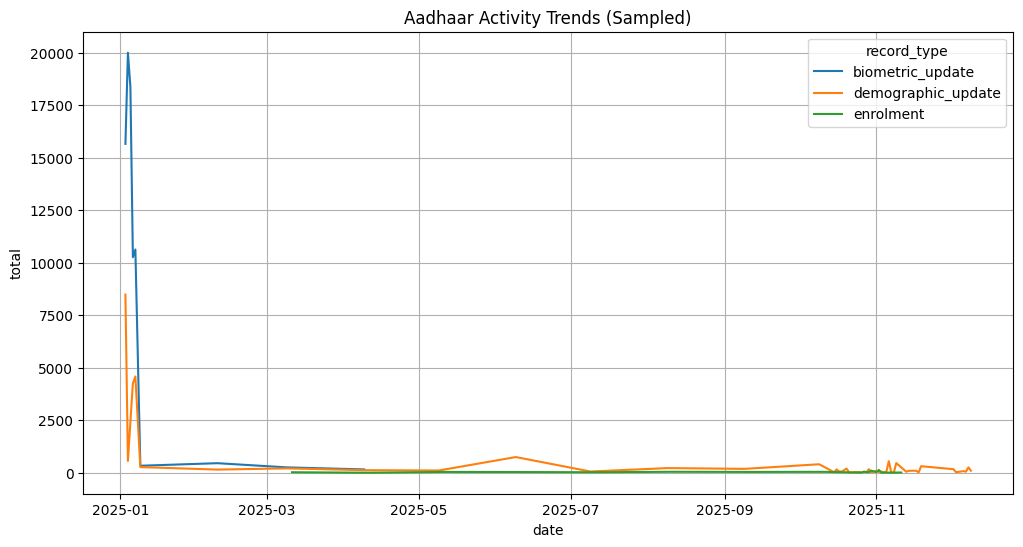

In [55]:
#trends and charts
monthly = combined_df.groupby(["date", "record_type"])["total"].sum().reset_index().sort_values("date")

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="date", y="total", hue="record_type")
plt.title("Aadhaar Activity Trends (Sampled)")
plt.grid(True)
plt.savefig(f"{CHART_DIR}/monthly_trend_by_type.png", dpi=200, bbox_inches="tight")
plt.show()


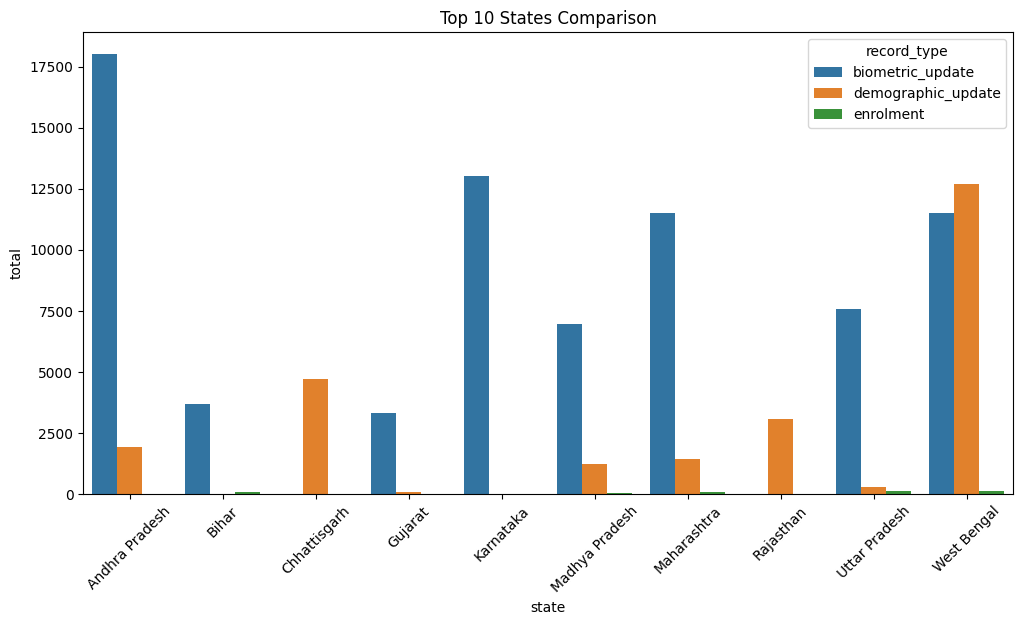

In [56]:
top_states = combined_df.groupby("state")["total"].sum().sort_values(ascending=False).head(10).index
state_total = combined_df[combined_df["state"].isin(top_states)].groupby(["state","record_type"])["total"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=state_total, x="state", y="total", hue="record_type")
plt.title("Top 10 States Comparison")
plt.xticks(rotation=45)
plt.savefig(f"{CHART_DIR}/top_states_activity.png", dpi=200, bbox_inches="tight")
plt.show()


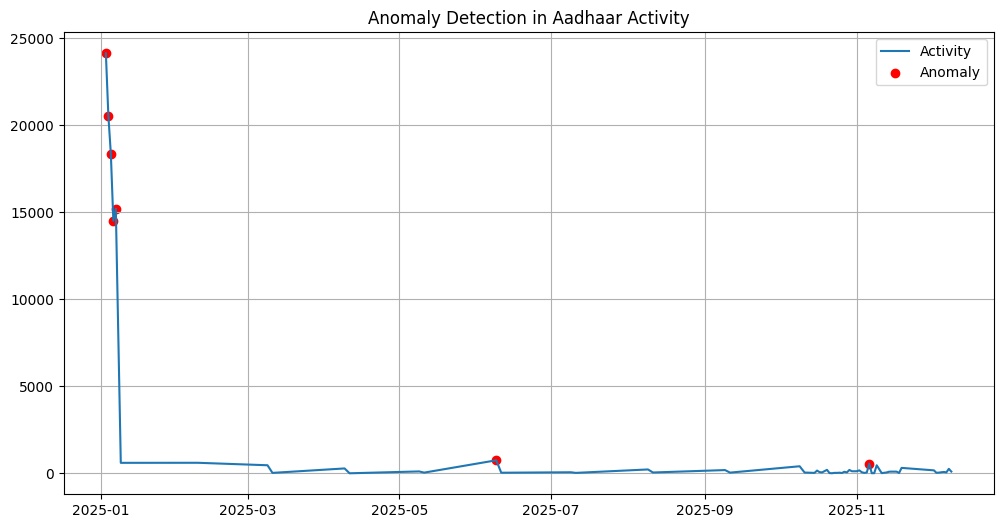

In [57]:
total_by_date = combined_df.groupby("date")["total"].sum().reset_index().sort_values("date")

if len(total_by_date) >= 10:
    scaler = StandardScaler()
    total_by_date["scaled"] = scaler.fit_transform(total_by_date[["total"]])

    iso = IsolationForest(contamination=0.1, random_state=RANDOM_SEED)
    total_by_date["anomaly"] = iso.fit_predict(total_by_date[["scaled"]])
    total_by_date["anomaly"] = total_by_date["anomaly"].map({1:0, -1:1})

    plt.figure(figsize=(12,6))
    plt.plot(total_by_date["date"], total_by_date["total"], label="Activity")
    plt.scatter(total_by_date[total_by_date["anomaly"]==1]["date"],
                total_by_date[total_by_date["anomaly"]==1]["total"],
                color="red", label="Anomaly")
    plt.title("Anomaly Detection in Aadhaar Activity")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{CHART_DIR}/anomaly_detection.png", dpi=200, bbox_inches="tight")
    plt.show()
else:
    print(" Not enough unique dates for anomaly detection.")


In [58]:
summary = pd.DataFrame({
    "Metric": [
        "Total sampled rows",
        "Available date range",
        "Most active state",
        "Most active record type"
    ],
    "Value": [
        len(combined_df),
        f"{combined_df['date'].min().date()} to {combined_df['date'].max().date()}",
        combined_df.groupby("state")["total"].sum().sort_values(ascending=False).index[0],
        combined_df.groupby("record_type")["total"].sum().sort_values(ascending=False).index[0]
    ]
})

summary_path = f"{OUT_DIR}/summary_insights.csv"
summary.to_csv(summary_path, index=False)
print(" Summary saved:", summary_path)

summary


 Summary saved: /content/drive/MyDrive/aadhaar_hackathon/outputs/summary_insights.csv


,Metric,Value
0,Total sampled rows,1118
1,Available date range,2025-01-03 to 2025-12-09
2,Most active state,West Bengal
3,Most active record type,biometric_update


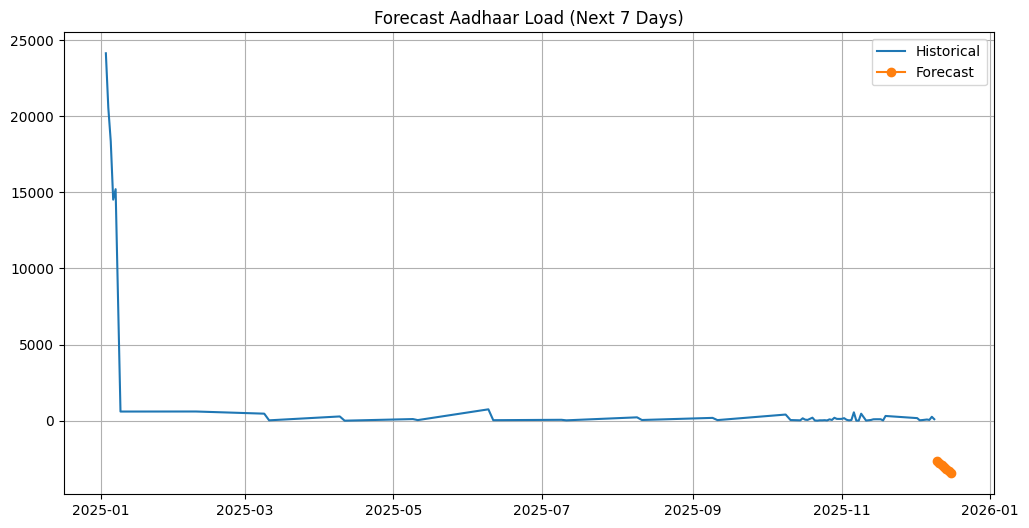

In [59]:
#forecasting
if len(total_by_date) >= 15:
    total_by_date["t"] = np.arange(len(total_by_date))

    X = total_by_date[["t"]]
    y = total_by_date["total"]

    reg = LinearRegression()
    reg.fit(X, y)

    FUTURE_DAYS = 7
    future_t = np.arange(len(total_by_date), len(total_by_date)+FUTURE_DAYS).reshape(-1,1)
    preds = reg.predict(future_t)

    future_dates = pd.date_range(
        start=total_by_date["date"].max(),
        periods=FUTURE_DAYS+1,
        freq="D"
    )[1:]

    plt.figure(figsize=(12,6))
    plt.plot(total_by_date["date"], y, label="Historical")
    plt.plot(future_dates, preds, marker="o", label="Forecast")
    plt.title("Forecast Aadhaar Load (Next 7 Days)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{CHART_DIR}/forecast_next_7_days.png", dpi=200, bbox_inches="tight")
    plt.show()
else:
    print("Not enough unique dates for forecasting.")


In [60]:
summary = pd.DataFrame({
    "Metric": [
        "Total sampled rows",
        "Available date range",
        "Most active state",
        "Most active record type"
    ],
    "Value": [
        len(combined_df),
        f"{combined_df['date'].min().date()} to {combined_df['date'].max().date()}",
        combined_df.groupby("state")["total"].sum().sort_values(ascending=False).index[0],
        combined_df.groupby("record_type")["total"].sum().sort_values(ascending=False).index[0]
    ]
})

summary_path = f"{OUT_DIR}/summary_insights.csv"
summary.to_csv(summary_path, index=False)

print(" Summary insights saved to:", summary_path)
summary


 Summary insights saved to: /content/drive/MyDrive/aadhaar_hackathon/outputs/summary_insights.csv


,Metric,Value
0,Total sampled rows,1118
1,Available date range,2025-01-03 to 2025-12-09
2,Most active state,West Bengal
3,Most active record type,biometric_update


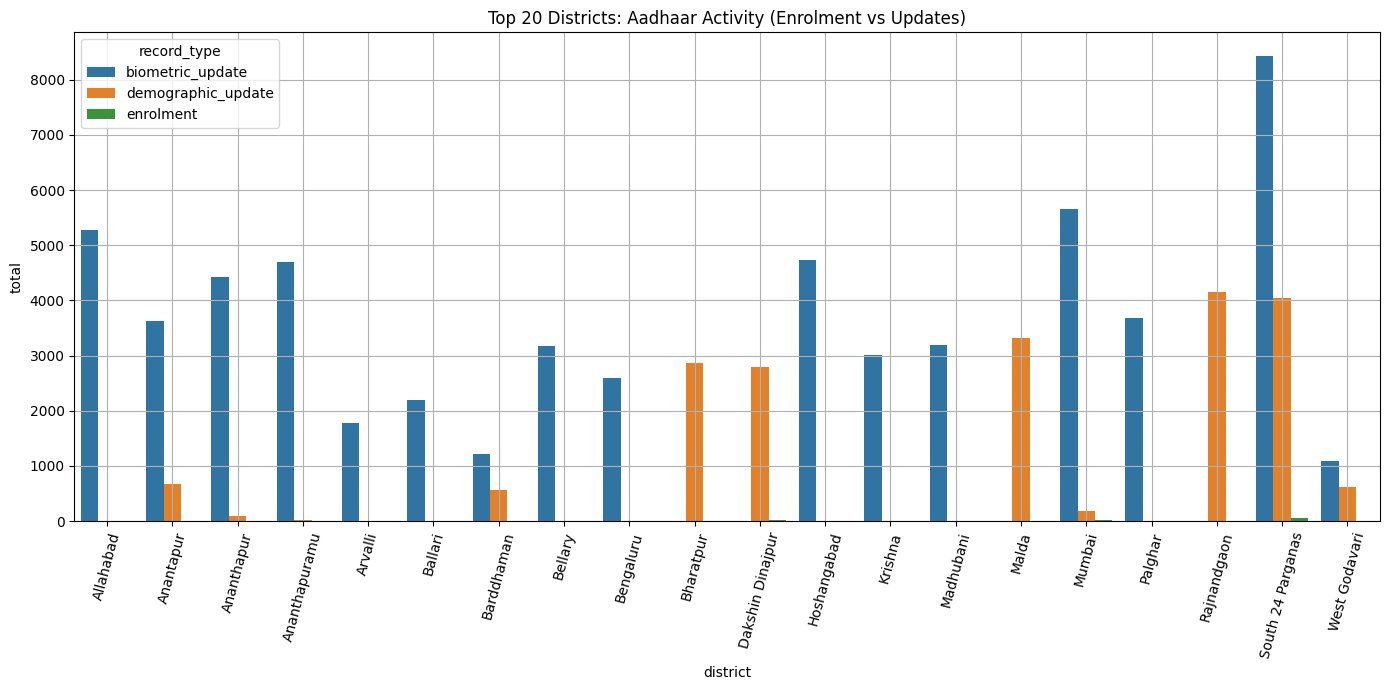

In [61]:
top_districts = (df.groupby("district")["total"]
                 .sum()
                 .sort_values(ascending=False)
                 .head(20)
                 .index)

district_summary = (df[df["district"].isin(top_districts)]
                    .groupby(["district", "record_type"])["total"]
                    .sum()
                    .reset_index())

plt.figure(figsize=(14,7))
sns.barplot(data=district_summary, x="district", y="total", hue="record_type")
plt.title("Top 20 Districts: Aadhaar Activity (Enrolment vs Updates)")
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/top_20_districts.png", dpi=200)
plt.show()


In [62]:
top_pincode_table = (df.groupby("pincode")["total"]
                     .sum()
                     .sort_values(ascending=False)
                     .head(25)
                     .reset_index())

top_pincode_table.to_csv("/content/drive/MyDrive/aadhaar_hackathon/outputs/top_25_pincodes.csv", index=False)
top_pincode_table


,pincode,total
0,743502,5532
1,211003,5438
2,400072,5040
3,461223,4799
4,401305,4214
5,743329,4162
6,491661,3997
7,560043,3645
8,515671,3554
9,732123,3390


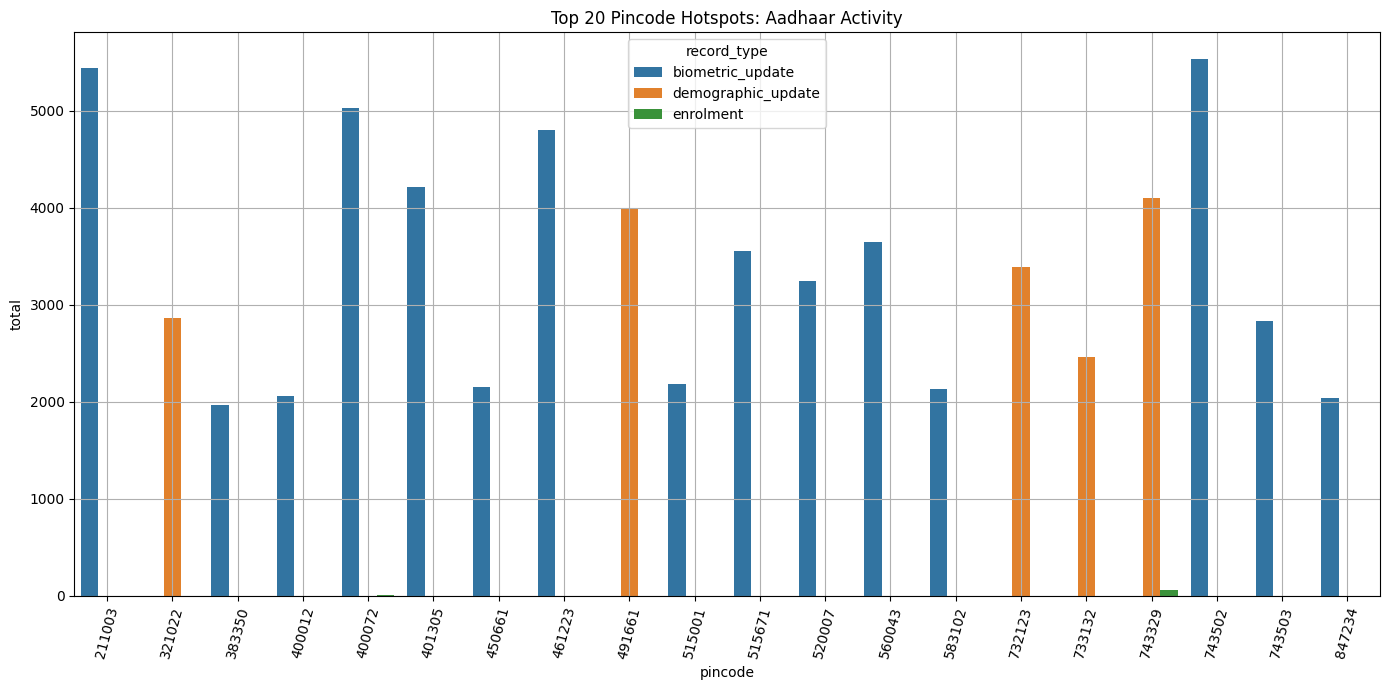

In [63]:
top_pins = top_pincode_table.head(20)["pincode"]

pin_summary = (df[df["pincode"].isin(top_pins)]
               .groupby(["pincode", "record_type"])["total"]
               .sum()
               .reset_index())

plt.figure(figsize=(14,7))
sns.barplot(data=pin_summary, x="pincode", y="total", hue="record_type")
plt.title("Top 20 Pincode Hotspots: Aadhaar Activity")
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/top_20_pincodes.png", dpi=200)
plt.show()


In [64]:
#UpdatePressure = (Demographic + Biometric) / Enrolment
state_type = df.groupby(["state", "record_type"])["total"].sum().unstack(fill_value=0)

# safe division
state_type["update_pressure_ratio"] = (
    (state_type.get("demographic_update", 0) + state_type.get("biometric_update", 0)) /
    (state_type.get("enrolment", 1))
)

update_pressure = state_type["update_pressure_ratio"].sort_values(ascending=False).head(15)
update_pressure.to_csv("/content/drive/MyDrive/aadhaar_hackathon/outputs/top_15_update_pressure_states.csv")

update_pressure


,update_pressure_ratio
state,
Andhra Pradesh,inf
Chhattisgarh,inf
Karnataka,inf
Madhya Pradesh,167.183673
Maharashtra,161.762500
West Bengal,156.277419
Rajasthan,146.000000
Gujarat,103.909091
Uttar Pradesh,50.812903


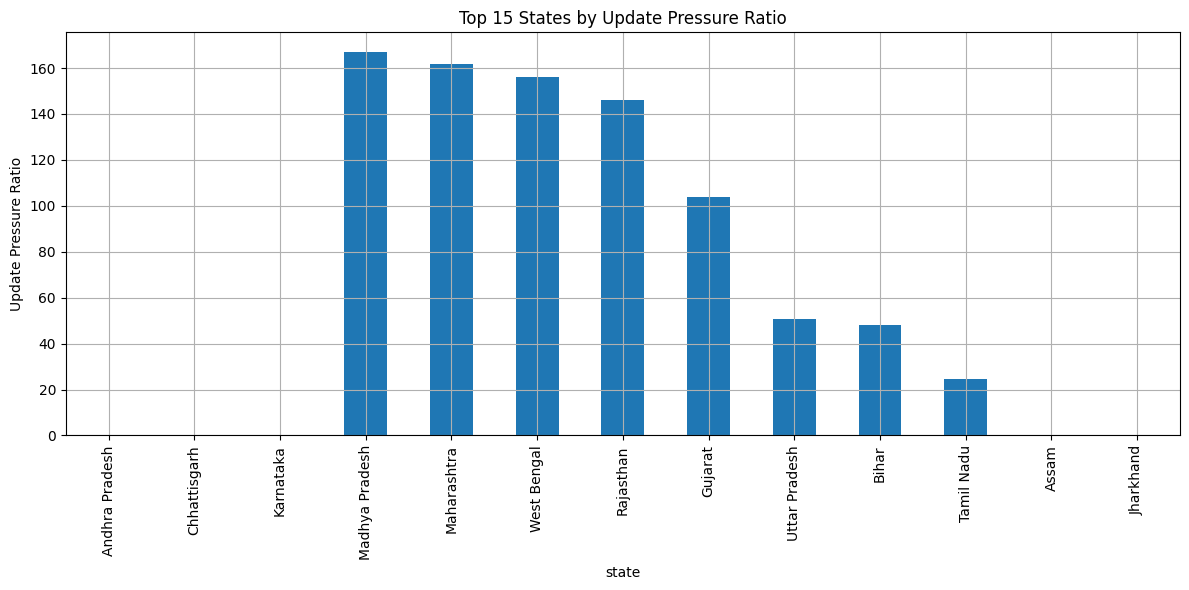

In [65]:
plt.figure(figsize=(12,6))
update_pressure.plot(kind="bar")
plt.title("Top 15 States by Update Pressure Ratio")
plt.ylabel("Update Pressure Ratio")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/update_pressure_states.png", dpi=200)
plt.show()


In [66]:
#Adult share % per state
state_age = df.groupby("state")[["age_5_17", "age_18_greater"]].sum()
state_age["adult_share_%"] = (state_age["age_18_greater"] / (state_age["age_5_17"] + state_age["age_18_greater"])) * 100

adult_share = state_age["adult_share_%"].sort_values(ascending=False).head(15)
adult_share.to_csv("/content/drive/MyDrive/aadhaar_hackathon/outputs/top_15_adult_share_states.csv")

adult_share


,adult_share_%
state,
Rajasthan,93.650794
Chhattisgarh,92.712981
West Bengal,73.730413
Maharashtra,64.995008
Tamil Nadu,60.250391
Madhya Pradesh,53.743478
Karnataka,52.883803
Bihar,49.510453
Gujarat,41.709994


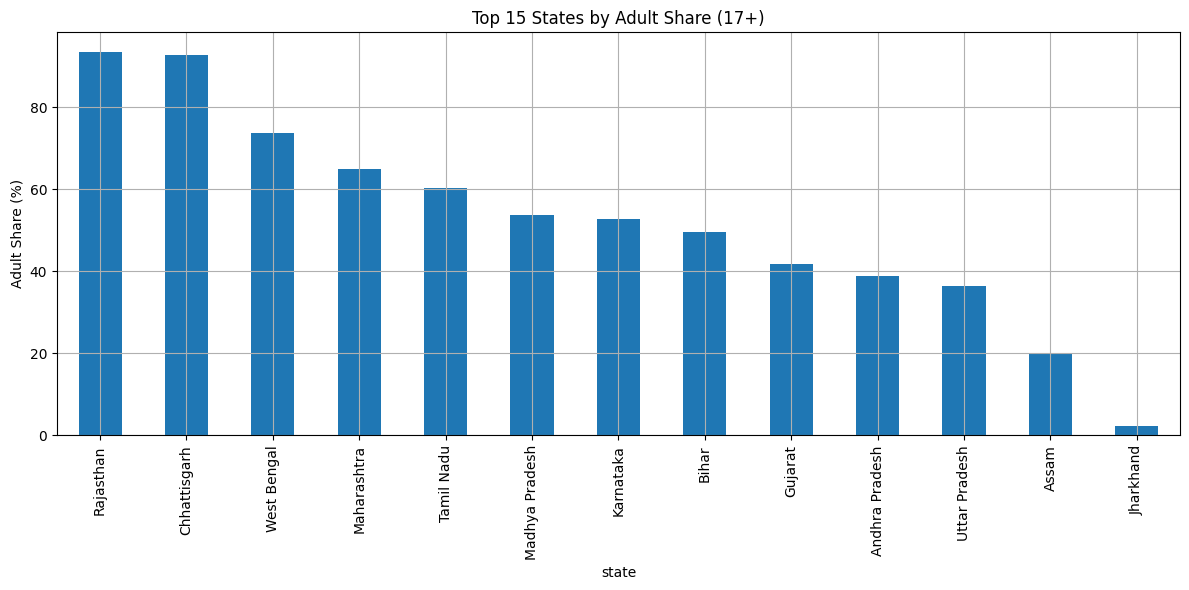

In [67]:
plt.figure(figsize=(12,6))
adult_share.plot(kind="bar")
plt.title("Top 15 States by Adult Share (17+)")
plt.ylabel("Adult Share (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/adult_share_states.png", dpi=200)
plt.show()


In [68]:
#Anomaly dates
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

daily_total = df.groupby("date")["total"].sum().reset_index().sort_values("date")

scaler = StandardScaler()
daily_total["scaled"] = scaler.fit_transform(daily_total[["total"]])

iso = IsolationForest(contamination=0.1, random_state=42)
daily_total["anomaly"] = iso.fit_predict(daily_total[["scaled"]])
daily_total["anomaly"] = daily_total["anomaly"].map({1:0, -1:1})

anomaly_dates = daily_total[daily_total["anomaly"] == 1]["date"].tolist()
print("Anomaly dates:", anomaly_dates)


Anomaly dates: ['2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-06-09', '2025-11-06']


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


df["date"] = pd.to_datetime(df["date"], errors="coerce")

daily = (
    df.groupby("date")["total"]
    .sum()
    .reset_index()
    .sort_values("date")
)

# fill missing dates
full_dates = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")
daily = daily.set_index("date").reindex(full_dates).fillna(0).rename_axis("date").reset_index()

print(" Daily points:", len(daily))
daily.head()


 Daily points: 341


,date,total
0,2025-01-03,24135.0
1,2025-01-04,20557.0
2,2025-01-05,18361.0
3,2025-01-06,14521.0
4,2025-01-07,15207.0


In [70]:

#2) Outlier handling (Winsorization)

q1 = daily["total"].quantile(0.25)
q3 = daily["total"].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 3 * iqr
lower_bound = max(0, q1 - 3 * iqr)

daily["total_clean"] = daily["total"].clip(lower=lower_bound, upper=upper_bound)


daily["smooth"] = daily["total_clean"].rolling(window=7, min_periods=1).median()

daily[["date", "total", "total_clean", "smooth"]].head(10)


,date,total,total_clean,smooth
0,2025-01-03,24135.0,0.0,0.0
1,2025-01-04,20557.0,0.0,0.0
2,2025-01-05,18361.0,0.0,0.0
3,2025-01-06,14521.0,0.0,0.0
4,2025-01-07,15207.0,0.0,0.0
5,2025-01-08,0.0,0.0,0.0
6,2025-01-09,600.0,0.0,0.0
7,2025-01-10,0.0,0.0,0.0
8,2025-01-11,0.0,0.0,0.0
9,2025-01-12,0.0,0.0,0.0


In [71]:

# 4) Forecast using log transform

daily["y"] = np.log1p(daily["smooth"])

daily["t"] = np.arange(len(daily))

X = daily[["t"]]
y = daily["y"]

# Train-test split (last 14 days as test)
test_days = 14
X_train, X_test = X.iloc[:-test_days], X.iloc[-test_days:]
y_train, y_test = y.iloc[:-test_days], y.iloc[-test_days:]

model = LinearRegression()
model.fit(X_train, y_train)

# predictions on test
test_pred = model.predict(X_test)


test_pred_actual = np.expm1(test_pred)
y_test_actual = np.expm1(y_test)

# metrics
mae = mean_absolute_error(y_test_actual, test_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred_actual))

print(f"Forecast Evaluation (last {test_days} days): MAE={mae:.2f}, RMSE={rmse:.2f}")


Forecast Evaluation (last 14 days): MAE=0.00, RMSE=0.00


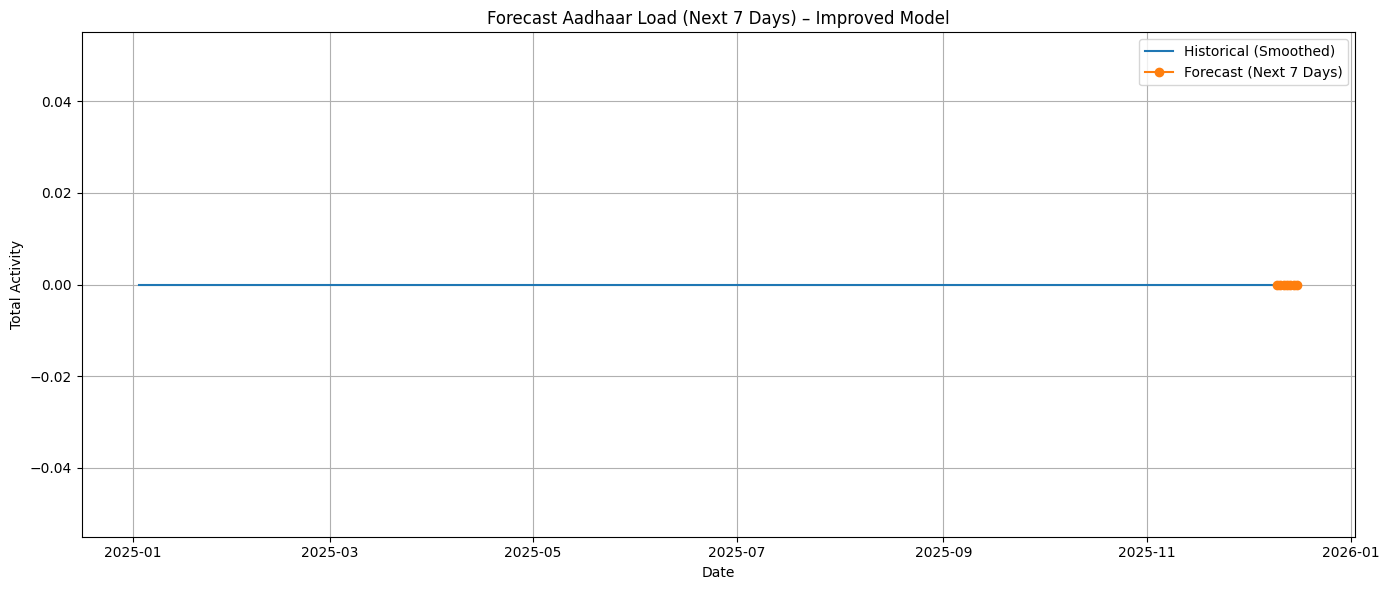

 Improved forecast plot saved to: /content/drive/MyDrive/aadhaar_hackathon/outputs/charts/forecast_next_7_days_improved.png


In [72]:

FUTURE_DAYS = 7

future_t = np.arange(len(daily), len(daily) + FUTURE_DAYS).reshape(-1, 1)
future_log_pred = model.predict(future_t)

future_pred = np.expm1(future_log_pred)

# ensure non-negative
future_pred = np.clip(future_pred, 0, None)

future_dates = pd.date_range(daily["date"].max() + pd.Timedelta(days=1), periods=FUTURE_DAYS, freq="D")


plt.figure(figsize=(14,6))

plt.plot(daily["date"], daily["smooth"], label="Historical (Smoothed)")
plt.plot(future_dates, future_pred, marker="o", label="Forecast (Next 7 Days)")

plt.title("Forecast Aadhaar Load (Next 7 Days) – Improved Model")
plt.xlabel("Date")
plt.ylabel("Total Activity")
plt.grid(True)
plt.legend()
plt.tight_layout()


save_path = "/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/forecast_next_7_days_improved.png"
plt.savefig(save_path, dpi=200, bbox_inches="tight")

plt.show()

print(" Improved forecast plot saved to:", save_path)
